# **Deep Q-Network Route Finder**

Here in this jupyter notebook, we will have some fun with using reinforcement learning to find safe routes across the ice.
This notebook draws a lot of inspiration from Open AI's [FrozenLake](https://gym.openai.com/envs/FrozenLake8x8-v0/) gym environment.
Really, how nice of them to have a well crafted toy problem already thought out for us!

Specifically and technically, we will train a Deep Q-Network in Keras/Tensorflow to help us decide safe routes across slippery ice!
Later, we will move on to applying this safe navigation tool to our crevasse avoidance problem.

References:
- Open AI [gym](https://github.com/openai/gym) 
- [Simple Reinforcement Learning with Tensorflow Part 0: Q-Learning with Tables and Neural Networks](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0)
- [Simple Reinforcement Learning with Tensorflow Part 4: Deep Q-Networks and Beyond](https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-4-deep-q-networks-and-beyond-8438a3e2b8df)
- [Frozen Lake github gist using Keras](https://gist.github.com/ceshine/eeb97564c21a77b8c315179f82b3fc08)
- [Reinforcement Learning w/ Keras + OpenAI: DQNs](https://towardsdatascience.com/reinforcement-learning-w-keras-openai-dqns-1eed3a5338c)
- [Introduction to Various Reinforcement Learning Algorithms. Part I (Q-Learning, SARSA, DQN, DDPG)](https://towardsdatascience.com/introduction-to-various-reinforcement-learning-algorithms-i-q-learning-sarsa-dqn-ddpg-72a5e0cb6287)

In [1]:
# Import all the necessary libraries
import os
import sys
import warnings
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  #set to see only the first gpu
os.environ['KERAS_BACKEND'] = 'tensorflow'
warnings.simplefilter(action = "ignore", category = FutureWarning)

import gym
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

import keras
import tensorflow as tf
import rl

from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Conv2D, Flatten, Dense, Input, SeparableConv2D
from keras.layers.core import Activation, Flatten, Dropout, Reshape
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)
tf.test.gpu_device_name()

Using TensorFlow backend.


Python       : 3.6.5 | packaged by conda-forge | (default, Apr  6 2018, 13:39:56) 
Numpy        : 1.14.2
Keras        : 2.1.5
Tensorflow   : 1.4.1


'/device:GPU:0'

In [2]:
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)
tf.set_random_seed(seed=seed)

## Design Keras Model to fit into Q-Network

In [3]:
def keras_convnet(input_shape=(8,8,2)):
    """
    The Keras Convolutional Network that parses the incoming pixel data.
    Based on Mnih et al. 2015's "Playing Atari with Deep Reinforcement Learning" paper
    Consists of 2 Convolutional Layers, and 1 Dense Layer, plus 1 Linear output Layer
    
    Inputs:
    input_shape -- shape of the input tensor, (height, width, channels)
    
    Outputs:
    model -- keras.models.Model instance
    
    """
    inp = Input(shape=input_shape)
    assert(inp.shape.ndims == 4)  #needs to be shape like (?,4,4,2) for 4x4 grid, (?,8,8,2) for 8x8 grid
        
    X = Conv2D(filters=16, kernel_size=(8,8), strides=(4,4), padding='same', activation='relu')(inp)
    X = Conv2D(filters=32, kernel_size=(4,4), strides=(2,2), padding='same', activation='relu')(X)
    X = Flatten()(X)
    X = Dense(units=256, activation='relu')(X)
    X = Dense(units=4, activation='linear')(X)
    
    model = Model(inputs=inp, outputs=X) 
    
    return model

# CrevasseCrosser gym environment

## Implement our own CrevasseCrosser class based on OpenAI FrozenLake gym

Borrows some elements from https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py

**Note**: There are a lot of Python classes wrapping functions to implement this CrevasseCrosserEnv (read: can be hard to follow if you're not familiar with the OpenAI gym). If you are looking for the previous pure numpy implementation that more clearly illustrates the mechanics, you can check out an older version at this [git commit](https://github.com/weiji14/nz_space_challenge/blob/11c293a1c30029b4717c0e40111c56f047dea3c0/route_finder.ipynb).

### Design map grid environment

In [4]:
MAPS = { "8x8custom":
           np.array([[.01, .01, .01, .01, .01, .01, .01, .01],
                     [.01, .01, .01, .01, .01, .01, .01, .01],
                     [.01, .01, .01, 5.0, .01, .01, .01, .01],
                     [.01, .01, .01, .01, .01, 5.0, .01, .01],
                     [.01, .01, .01, 5.0, .01, .01, .01, .01],
                     [.01, 5.0, 5.0, .01, .01, .01, 5.0, .01],
                     [.01, 5.0, .01, .01, 5.0, .01, 5.0, .01],
                     [.01, .01, .01, 5.0, .01, .01, .01, -5.]], dtype=np.float)
        }

### Helper function to convert integer to a 2D grid location

In [5]:
def int_to_grid(integer:int, grid_shape=(4,4)):
    """
    Function to map an integer to it's 2D grid location
    
    E.g. to place the integer 5 in a 4x4 (height*width) grid
    
            0000
    5   ->  0100
            0000
            0000
            
    Steps:
    1) np.prod(grid_shape) i.e. 4*4=16
    2) np.identity(16)[integer:integer+1] i.e. output something like [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]
    3) np.reshape(grid_shape) i.e. output the grid form of the above
    """
    assert(len(grid_shape) == 2)  #numpy array shape must be (height, width) i.e. 2 dimensional
    return np.identity(np.prod(grid_shape))[integer:integer+1].reshape(grid_shape)

### **CrevasseCrosser** custom OpenAI gym environment class!

In [6]:
#https://stackoverflow.com/questions/45068568/is-it-possible-to-create-a-new-gym-environment-in-openai/47132897#47132897
from gym.envs import toy_text
from gym.utils import seeding

class CrevasseCrosserEnv(toy_text.discrete.DiscreteEnv):
    """
    A duplicate of the OpenAI gym FrozenLake, designed with a custom map in mind!
    
    The map should be a 2D numpy array, with values on each xy position indicating the
    penalty for stepping on to that position.
    
    E.g. if values range from -5 to +5
    +5 would indicate a hole or 'H' in the FrozenLake env
    -5 would indicate the goal or 'G' in the FrozenLake env
    +0.1 would be the free spot or 'F' in the FrozenLake env, note that we penalize steps    
    The starting point 'S' on the top left would also have a value of +0.1
    
    """
    
    def __init__(self, desc=None, map_name="8x8custom"):
        if desc is None and map_name is None:
            raise ValueError('Must provide either desc or map_name')
        elif desc is None:
            desc = MAPS[map_name]
        try:
            assert(isinstance(desc, np.ndarray))
            self.desc = desc
        except AssertionError:
            self.desc = desc = np.asarray(desc,dtype='c')
        
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (np.min(desc), np.max(desc))  #(0, 1) in FrozenLake, (-5, 5) in '8x8custom' environment
        self.reward_extremes = list(self.reward_range)    #[-5, 5], alias for reward_range
        
        ## number of Actions (discrete)
        ## Define what our agent can do, i.e. move left, down, right, up
        nA = 4            #self.action_space = gym.spaces.Discrete(nA)
        
        ## number of States (discrete)
        ## Define the shape of our map grid, i.e. number of rows times columns
        nS = nrow * ncol  #self.observation_space = gym.spaces.Discrete(self.nS)
        
        ## initial state distribution (list or array of length nS)
        ## Basicaly the initial position of our player as a flattened numpy array
        isd = np.identity(np.prod(nrow*ncol))[0:0+1]  #assign initial position as top left
        
        #safe_points = list(np.argsort(a=self.desc.flatten())[1:21])       #get 20 minimum (safe) points excluding goal
        #random_safe_point = random.sample(population=safe_points, k=1)[0]  #randomly choose one safe point
        #isd = np.identity(np.prod(nrow*ncol))[random_safe_point:random_safe_point+1]  #assign safe point as initial position
        
        ## transitions (dictionary dict of dicts of lists, where
        ## P[s][a] == [(probability, nextstate, reward, done), ...])
        P = {s : {a : [] for a in range(nA)} for s in range(nS)}
        
        def to_s(row, col):
            """
            Function to return index position of flattened map grid
            E.g. (row, col) = (1,1) for a 4x4 grid returns 5
            """
            assert(row <= nrow)
            assert(col <= ncol)
            return row*ncol + col
        
        def inc(row, col, a):
            """
            Function to help us take a step somewhere!
            """
            if a==0: # left
                col = max(col-1,0)
            elif a==1: # down
                row = min(row+1,nrow-1)
            elif a==2: # right
                col = min(col+1,ncol-1)
            elif a==3: # up
                row = max(row-1,0)
            return (row, col)
        
        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)    #return index number position given row, col
                for a in range(nA):   #for actions in the range of possible actions
                    li = P[s][a]      #P[s][a] == [(probability, nextstate, reward, done), ...])
                    #letter = desc[row, col]
                    gridvalue = desc[row, col]  #the gridvalue corresponding to the penalty value at a position on the map
                    probability = 1.0
                    #if letter in b'GH':
                    if gridvalue in self.reward_extremes:  #if we are already at the goal or the hole
                        nextstate = s  #remain in the same position
                        reward = 0     #no reward since we are at the end
                        done = True
                    else:
                        newrow, newcol = inc(row, col, a)    #make a move based on our action
                        nextstate = to_s(newrow, newcol)     #new index position
                        newgridvalue = desc[newrow, newcol]  #new position on the grid
                        reward = -newgridvalue               #reward is negative of grid value
                        done = True if gridvalue in self.reward_extremes else False
                    li.append((probability, nextstate, reward, done))
        
        super().__init__(nS, nA, P, isd)
    
    def render(self, mode='human'):
        """
        Matplotlib function to plot the player position on the left
        and the map_grid position on the right
        """
        player_position = int_to_grid(self.s, grid_shape=(self.ncol, self.nrow))
        map_grid = self.desc  #copy the map environment
        
        assert(player_position.shape == map_grid.shape)
        
        fig, axarr = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(5,5))
        axarr[0, 0].imshow(X=player_position, cmap='winter')
        axarr[0, 1].imshow(X=-map_grid, cmap='BrBG')
        
        if self.lastaction is not None:
            print("  ({})".format(["Left","Down","Right","Up"][self.lastaction]))
        else:
            print("")
        return plt.show()
    
    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed=seed)
        return [seed]

### Crevasse Environment Processor

In [7]:
# Refer to https://github.com/keras-rl/keras-rl/blob/master/examples/dqn_atari.py
from rl.core import Processor

class CrevasseEnvProcessor(Processor):
    """
    This processor takes the env observation (index position of the player)
    and returns a stacked 2 channel 2D array of shape (?, height, width, 2)
    containing the player position (channel 1) and the map grid (channel 2)
    """    
    def process_observation(self, observation):
        #print(observation.__class__)
        #assert(np.issubdtype(observation, np.int))
        #assert(isinstance(observation, int))
        map_grid = MAPS['8x8custom']
        player_position = int_to_grid(observation, grid_shape=map_grid.shape)
        processed_observation = np.stack([np.stack([player_position, map_grid], axis=-1)])  #stack the player_position array and map_grid array channel/depth-wise
        return processed_observation
        
    def process_state_batch(self, batch):
        #print(batch.shape)
        processed_batch = np.concatenate(np.concatenate(batch, axis=0), axis=0)
        assert(processed_batch.ndim == 4)
        #assert(processed_batch.shape == (1,8,8,2))
        return processed_batch

# Setup the training environment

In [8]:
env = CrevasseCrosserEnv()
env.seed(seed=seed)

[42]

  (Left)


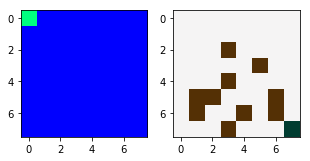

0 -0.01 False {'prob': 1.0}


In [9]:
env.reset()
observation, reward, done, info = env.step(env.action_space.sample())
env.render()
print(observation, reward, done, info)

### Build and compile the Deep Q-Network(DQN) model

Referred to implementation at https://github.com/keras-rl/keras-rl/blob/master/examples/dqn_atari.py

In [10]:
# Arguments to pass into dqn_model.fit
episodes = 1200               #rough number of episodes we want to train the model on
nb_max_episode_steps = 100    #maximum number of steps per episode before stopping the player

# Assuming an episode finishes in a quarter of the max_episode_steps
nb_steps= episodes * (nb_max_episode_steps/4)   #number of steps corresponding to roughly 1200 episodes
log_interval = 200 * (nb_max_episode_steps/4)   #print log data for roughly every +/-200 episodes

In [11]:
## Keras Model parameters
optimizer = keras.optimizers.Adam(lr=0.001)
model = keras_convnet(input_shape=(MAPS['8x8custom'].shape+(2,)))

## Deep Q-Network parameters
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1.0, value_min=0.1, value_test=0.05, nb_steps=nb_steps)
processor = CrevasseEnvProcessor()
nb_actions = env.action_space.n
memory = SequentialMemory(limit=1000, window_length=1)

## Compile the DQN Agent
dqn_model = DQNAgent(model=model, policy=policy,
                     memory=memory, processor=processor,
                     nb_actions=nb_actions, nb_steps_warmup=50,
                     batch_size=32, target_model_update=100,
                     enable_double_dqn=True, enable_dueling_network=True)
dqn_model.compile(optimizer=optimizer)
dqn_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8, 8, 2)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 16)          2064      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 32)          8224      
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8448      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
_________________________________________________________________
lambda_1 (Lambda)            (None, 4)                 0         
Total para

### **Train the Deep Q-Network iteratively here**

In [12]:
print(f"Training for ~{episodes} episodes with max {nb_max_episode_steps} steps, logging every {log_interval} steps")
dqn_model.fit(env=env, nb_steps=nb_steps, log_interval=log_interval, nb_max_episode_steps=nb_max_episode_steps)

Training for ~1200 episodes with max 100 steps, logging every 5000.0 steps
Training for 30000.0 steps ...
Interval 1.0 (0 steps performed)
5000/5000 [==============================] - 75s 15ms/step - reward: -0.1584
152 episodes - episode_reward: -5.207 [-5.970, -1.000] - loss: 0.075 - mean_q: 0.761 - mean_eps: 0.924 - prob: 1.000

Interval 2.0 (5000 steps performed)
5000/5000 [==============================] - 72s 14ms/step - reward: -0.1634
159 episodes - episode_reward: -5.140 [-5.980, -1.000] - loss: 0.025 - mean_q: 2.692 - mean_eps: 0.775 - prob: 1.000

Interval 3.0 (10000 steps performed)
5000/5000 [==============================] - 72s 14ms/step - reward: -0.1425
139 episodes - episode_reward: -5.125 [-5.900, -1.000] - loss: 0.023 - mean_q: 3.568 - mean_eps: 0.625 - prob: 1.000

Interval 4.0 (15000 steps performed)
5000/5000 [==============================] - 71s 14ms/step - reward: -0.0967
102 episodes - episode_reward: -4.737 [-5.990, -1.000] - loss: 0.035 - mean_q: 3.426 - me

TODO: Make an Asynchronous Advantage Actor-Critic A3C implementation in Keras!

References:

- [Reinforcement Learning w/ Keras + OpenAI: Actor-Critic Models](https://towardsdatascience.com/reinforcement-learning-w-keras-openai-actor-critic-models-f084612cfd69)
- [Let’s make an A3C: Implementation](https://jaromiru.com/2017/03/26/lets-make-an-a3c-implementation/)
- [Deep Reinforcement Learning Flappy Bird](https://shalabhsingh.github.io/Deep-RL-Flappy-Bird/)
- [Asynchronous Advantage Actor-Critic (A3C) (Tensorflow)](https://morvanzhou.github.io/tutorials/machine-learning/reinforcement-learning/6-3-A3C/)

### Save the DQN model!

In [13]:
dqn_model.save_weights(filepath='model/weights/dqn-model-weights.hdf5', overwrite=True)

### See how our player does

In [14]:
dqn_model.load_weights(filepath='model/weights/dqn-model-weights.hdf5')  #reload the saved dqn model weights

Testing for 1 episodes ...
  (Right)


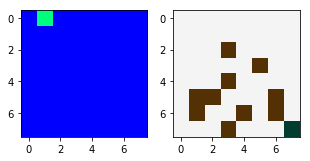

  (Up)


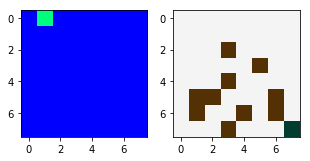

  (Up)


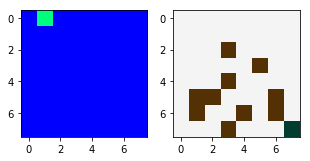

  (Up)


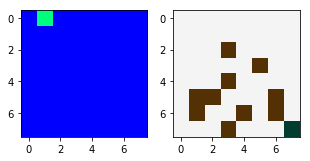

  (Up)


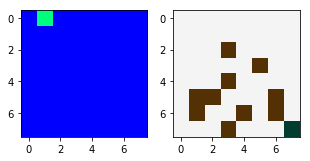

  (Up)


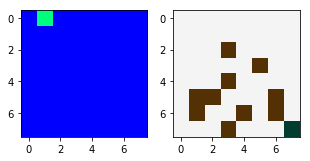

  (Up)


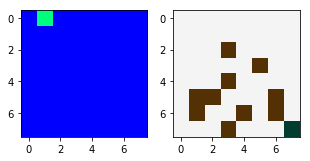

  (Up)


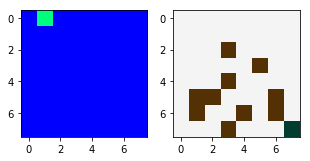

  (Up)


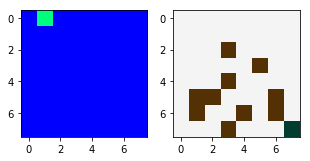

  (Up)


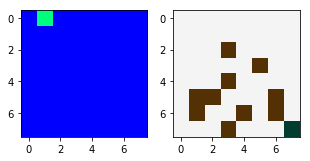

  (Up)


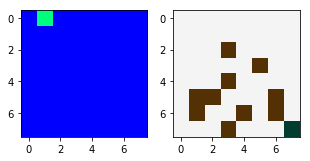

  (Up)


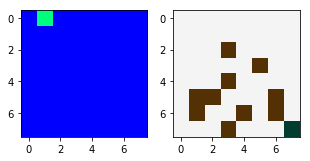

  (Up)


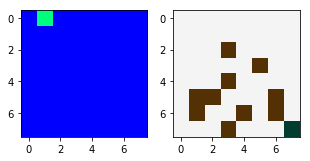

  (Up)


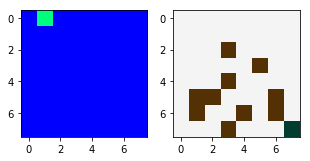

Episode 1: reward: -0.140, steps: 14
-0.13999999999999999


In [15]:
evaluation_info = dqn_model.test(env=env, nb_episodes=1, nb_max_episode_steps=14)
print(np.mean(evaluation_info.history['episode_reward']))